In [1]:
#import os
import sys
sys.path.append("../python/")
from helpers import *

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr
from itertools import combinations
from scipy.stats import ttest_ind, f_oneway # for independent t-test

In [2]:
SENSITIVITY_RESULTS_DIR = '../../results/sensitivity-tests-02272021'
SCENARIO_LIST = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]

In [3]:
def getPerformanceDataFrame():
    result_file_list = getListOfFiles(SENSITIVITY_RESULTS_DIR)
    df = pd.DataFrame()
    for filename in result_file_list:
        if "scenario_resolution_" in filename:
            performance_dict = json.load(open(filename))
            performance_df = pd.DataFrame(performance_dict["metrics"])
            performance_df['epoch'] = performance_df.index + 1
            performance_df["resolution"] = performance_dict["image_size"]
            performance_df["scenario"] = performance_dict["scenario"]
            #performance_df["best_val_accuracy"] = performance_dict["best_val_accuracy"]
            performance_df["trial"] = int(filename.split("_")[-1].split(".")[0])
            df = df.append(performance_df, ignore_index=True)
    return(df)

In [9]:
def getScenarioResolutionMeanPerformance():
    dp = getPerformanceDataFrame()
    dpagg = dp.groupby(['scenario','resolution','trial','epoch']).agg('max')
    df = dp.loc[dp.groupby(['scenario','resolution','trial'])['val_accuracy'].idxmax()]
    df = df.iloc[:,[3, 4,5,6, 8,9]]
    df = df.groupby(['scenario','resolution']).agg(['mean','std'])
    df = np.round(df, 2)
    df = df.reindex(index=["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"], level=0)
    df.to_csv('../../results/scenario-resolution-best-mean-std-performance.csv')    
    return df
getScenarioResolutionMeanPerformance()

val_accuracy       val_f1       val_recall        \
                            mean   std   mean   std       mean   std   
scenario resolution                                                    
Pr_Im    64                 0.94  0.01   0.92  0.02       0.90  0.02   
         128                0.95  0.01   0.93  0.02       0.91  0.03   
         224                0.94  0.01   0.92  0.01       0.91  0.01   
PrPo_Im  64                 0.92  0.01   0.91  0.01       0.91  0.02   
         128                0.92  0.01   0.91  0.01       0.90  0.01   
         224                0.91  0.01   0.91  0.01       0.90  0.01   
Pr_PoIm  64                 0.88  0.01   0.80  0.04       0.79  0.07   
         128                0.91  0.01   0.85  0.02       0.84  0.02   
         224                0.88  0.01   0.79  0.02       0.76  0.02   
Pr_Po_Im 64                 0.82  0.03   0.74  0.03       0.73  0.02   
         128                0.84  0.02   0.76  0.03       0.74  0.03   
         224                0.83  0.01   0.74  0.02       0.72  0.03   

                    val_precision        
                             mean   std  
scenario resolution                      
Pr_Im    64                  0.94  0.01  
         128                 0.95  0.01  
         224                 0.93  0.02  
PrPo_Im  64                  0.92  0.01  
         128                 0.92  0.01  
         224                 0.91  0.01  
Pr_PoIm  64                  0.85  0.05  
         128                 0.87  0.03  
         224                 0.84  0.03  
Pr_Po_Im 64                  0.75  0.04  
         128                 0.77  0.03  
         224                 0.76  0.01

In [392]:
print([c for c in combinations([64, 128, 224], 2)])

[(64, 128), (64, 224), (128, 224)]


In [158]:
print([ comb for comb in combinations(["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"], 2)])

[('Pr_Im', 'PrPo_Im'), ('Pr_Im', 'Pr_PoIm'), ('Pr_Im', 'Pr_Po_Im'), ('PrPo_Im', 'Pr_PoIm'), ('PrPo_Im', 'Pr_Po_Im'), ('Pr_PoIm', 'Pr_Po_Im')]


In [387]:
df = dp.loc[dp.groupby(['scenario','resolution','trial'])['val_accuracy'].idxmax()]
dpagg = df.set_index(['scenario','resolution','trial'])
dpmax = dpagg.iloc[:,3:7]

In [406]:
def resolutionPerformanceComparisonStats():
    dp = getPerformanceDataFrame()
    df = dp.loc[dp.groupby(['scenario','resolution','trial'])['val_accuracy'].idxmax()]
    dpagg = df.set_index(['scenario','resolution','trial'])
    dpmax = dpagg.iloc[:,3:7]
    dstats = pd.DataFrame(columns= ['Scenario', 'Resolution 1', 'Resolution 2',  'Accuracy', 'F1', 'Recall', 'Precision'])
    rowcounter = 0
    #print(dstats)
    for i in ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]:
        for j in combinations([64, 128, 224], 2):
            dstats.loc[rowcounter, ['Scenario', 'Resolution 1', 'Resolution 2'] ] = (i, j[0], j[1])
            tstats, pvals = ttest_ind(dpmax.loc[(i, j[0])], dpmax.loc[(i, j[1])], equal_var=False) 
            dstats.loc[rowcounter, ['Accuracy', 'F1', 'Recall', 'Precision']] = pvals
            rowcounter += 1
    dstats.to_csv('../../results/resolution-performance-comparison-stats.csv', index=False)
    return dstats
resolutionPerformanceComparisonStats()

,Scenario,Resolution 1,Resolution 2,Accuracy,F1,Recall,Precision
0,Pr_Im,64,128,0.427766,0.472000,0.638283,0.243409
1,Pr_Im,64,224,0.810526,0.957770,0.728743,0.400994
2,Pr_Im,128,224,0.333005,0.421449,0.781772,0.119129
3,PrPo_Im,64,128,0.343214,0.334622,0.280111,0.607451
4,PrPo_Im,64,224,0.112543,0.153209,0.299562,0.131835
5,PrPo_Im,128,224,0.465132,0.566733,0.978346,0.253573
6,Pr_PoIm,64,128,0.006932,0.037836,0.139458,0.345129
7,Pr_PoIm,64,224,0.836653,0.715576,0.494841,0.697297
8,Pr_PoIm,128,224,0.001099,0.000207,0.000467,0.076234
9,Pr_Po_Im,64,128,0.241587,0.249616,0.391389,0.311935


In [432]:
def scenarioPerformanceComparisonStats():
    dp = getPerformanceDataFrame()
    df = dp.loc[dp.groupby(['scenario','resolution','trial'])['val_accuracy'].idxmax()]
    dpagg = df.set_index(['scenario','resolution','trial'])
    dpmax = dpagg.iloc[:,3:7]
    rowcounter = 0
    #print(dstats)
    for i in [64, 128, 224]:
        for j in combinations(["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"], 2):
            dstats.loc[rowcounter, ['Resolution', 'Scenario 1', 'Scenario 2'] ] = (i, j[0], j[1])
            tstats, pvals = ttest_ind(dpmax.loc[(j[0], i)], dpmax.loc[(j[1], i)], equal_var=False)# ,dpmax.loc[("Pr_PoIm", 64)],dpmax.loc[("Pr_Po_Im", 64)]) 
            #print(pvals)
            #print([i, j[0], j[1]])#.append(pvals))
            dstats.loc[rowcounter, ['Accuracy', 'F1', 'Recall', 'Precision']] = pvals
            #dstats = dstats.append( pd.DataFrame({[i, j[0], j[1]].extend(pvals)}), ignore_index=True)
            rowcounter += 1
    dstats.to_csv('../../results/scenario-performance-comparison-stats.csv', index=False)
    return(dstats)
scenarioPerformanceComparisonStats()


,Resolution,Scenario 1,Scenario 2,Accuracy,F1,Recall,Precision
0,64,Pr_Im,PrPo_Im,0.005913,0.714479,0.422914,0.010639
1,64,Pr_Im,Pr_PoIm,0.000068,0.001772,0.014794,0.008354
2,64,Pr_Im,Pr_Po_Im,0.000184,0.000004,0.000004,0.000193
3,64,PrPo_Im,Pr_PoIm,0.000814,0.002534,0.010824,0.020167
4,64,PrPo_Im,Pr_Po_Im,0.000553,0.000014,0.000000,0.000351
5,64,Pr_PoIm,Pr_Po_Im,0.005380,0.029135,0.132204,0.007418
6,128,Pr_Im,PrPo_Im,0.004705,0.137997,0.578580,0.002389
7,128,Pr_Im,Pr_PoIm,0.001249,0.000455,0.003295,0.000790
8,128,Pr_Im,Pr_Po_Im,0.000005,0.000004,0.000012,0.000060
9,128,PrPo_Im,Pr_PoIm,0.169503,0.000446,0.001725,0.011313


In [395]:
dstats

,Resolution,Scenario 1,Scenario 2,Accuracy,F1,Recall,Precision
0,64,Pr_Im,PrPo_Im,0.005913,0.714479,0.422914,0.010639
1,64,Pr_Im,Pr_PoIm,0.000068,0.001772,0.014794,0.008354
2,64,Pr_Im,Pr_Po_Im,0.000184,0.000004,0.000004,0.000193
3,64,PrPo_Im,Pr_PoIm,0.000814,0.002534,0.010824,0.020167
4,64,PrPo_Im,Pr_Po_Im,0.000553,0.000014,0.000000,0.000351
5,64,Pr_PoIm,Pr_Po_Im,0.005380,0.029135,0.132204,0.007418
6,128,Pr_Im,PrPo_Im,0.004705,0.137997,0.578580,0.002389
7,128,Pr_Im,Pr_PoIm,0.001249,0.000455,0.003295,0.000790
8,128,Pr_Im,Pr_Po_Im,0.000005,0.000004,0.000012,0.000060
9,128,PrPo_Im,Pr_PoIm,0.169503,0.000446,0.001725,0.011313


<AxesSubplot:xlabel='epoch', ylabel='val_accuracy'>

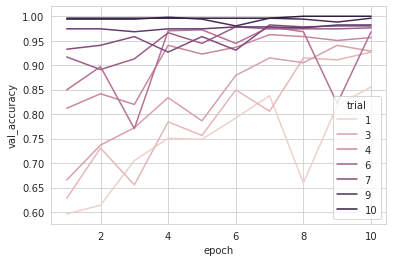

In [42]:
dd = dp[(dp.resolution == 64) &(dp.scenario == "PrPo_Im")]
sns.lineplot(x= 'epoch', y = 'val_accuracy', data = dd, hue = 'trial')

In [218]:
def plotMeanAccuracyLoss():
    df = getPerformanceDataFrame()
    melted_df = df.melt(id_vars = ["epoch", "resolution", "scenario"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy"], var_name = "metric", value_name = "value")
    melted_df["type"] = None
    melted_df.loc[melted_df.metric.isin(["loss", "val_loss"]), "type"] = "Loss"
    melted_df.loc[melted_df.metric.isin(["accuracy", "val_accuracy"]), "type"] = "Accuracy"
    
    num_scenarios = len(df.scenario.unique())
    num_resolutions = len(df.resolution.unique())
    num_epochs = df.epoch.max()
    sns.set_style("whitegrid")
    g = sns.FacetGrid(melted_df, col="scenario", row="type", sharey = False, col_order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"])
    g.map_dataframe(sns.lineplot, x = "epoch", y = "value", style = "metric",# style_order = ['Validation','Training'], 
                    hue = "resolution", palette= sns.color_palette("Set1", n_colors=num_resolutions) )
    g.set_axis_labels("Epoch", "",  fontsize=14)
    g.add_legend( fontsize=16) 
    ## Customize legend
    g._legend.texts[0].set_text("Resolution")
    g._legend.texts[num_resolutions + 1].set_text("Phase") #Data
    g._legend.texts[num_resolutions + 2].set_text("Training")
    g._legend.texts[num_resolutions + 3].set_text("Validation")    
    g._legend.texts[num_resolutions + 4].set_text("")    
    g._legend.texts[num_resolutions + 5].set_text("")    
    g._legend.legendHandles[num_resolutions + 4].set_linewidth(0)
    g._legend.legendHandles[num_resolutions + 5].set_linewidth(0)    
    g._legend._legend_box.sep = 5
    axes = g.axes
    for row, axlist in enumerate(axes):
        if row==0:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0, 2.25)#.75 
                axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].xaxis.set_major_locator(tkr.AutoLocator())
                axes[row, col].set_title("Scenario: " + 
                                         str(axes[row, col].title).split("scenario = ")[1].split(")")[0].split("\'")[0], fontsize=16)
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Loss", fontsize=14)
        elif row==1:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0.4, 1)
                axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].set_title("")
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Accuracy", fontsize=14)
    g.savefig("../../figures/scenario_resolution_performance.png", dpi=180)
    return(g)

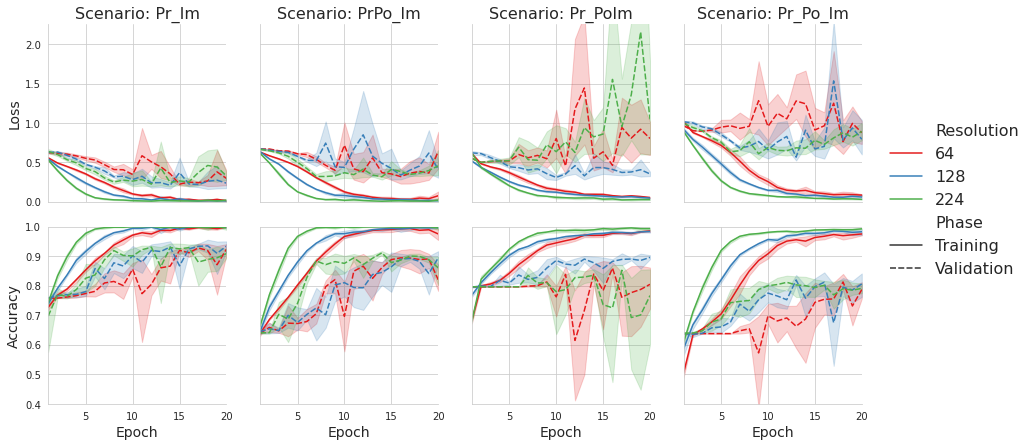

In [219]:
gg = plotMeanAccuracyLoss()

In [226]:
def testMeanValidationAccuracy():
    df = getPerformanceDataFrame()
    
    df = df[['scenario', "resolution", "trial", 'best_val_accuracy']].drop_duplicates()
    #df1['resolution'] = df1['resolution'].map(str)
    df = df.melt(id_vars = ['scenario', "resolution", "trial"], value_vars = ["best_val_accuracy"], var_name = "metric", value_name = "value")
    
    dfacc = df.groupby(["scenario", "resolution"]).mean()
    dfacc = dfacc.drop(["trial"], axis = 1)
    dfacc.columns = ['mean']
    dfacc['stdev'] = df.groupby(["scenario", "resolution"]).std()['value']
    print(np.round(dfacc,2))
    for s in SCENARIO_LIST:
        print(s)
        dfs = df[df.scenario==s]
        print("Test difference between resolutions 64 and 128")
        print(ttest_ind(dfs.loc[dfs.resolution==64,'value'], dfs.loc[dfs.resolution==128,'value'], equal_var=False))
        print("Test difference between resolutions 64 and 224")
        print(ttest_ind(dfs.loc[dfs.resolution==64,'value'], dfs.loc[dfs.resolution==224,'value'], equal_var=False))    
    return
testMeanValidationAccuracy()

                     mean  stdev
scenario resolution             
PrPo_Im  64          0.96   0.04
         128         0.96   0.05
         224         0.96   0.05
Pr_Im    64          0.98   0.03
         128         0.97   0.03
         224         0.97   0.03
Pr_PoIm  64          0.96   0.04
         128         0.97   0.04
         224         0.97   0.04
Pr_Po_Im 64          0.94   0.07
         128         0.95   0.07
         224         0.95   0.06
Pr_Im
Test difference between resolutions 64 and 128
Ttest_indResult(statistic=0.01976319227745044, pvalue=0.9844497250404811)
Test difference between resolutions 64 and 224
Ttest_indResult(statistic=0.24360063513619826, pvalue=0.8103062006606452)
PrPo_Im
Test difference between resolutions 64 and 128
Ttest_indResult(statistic=0.12736637270221182, pvalue=0.9000692161378825)
Test difference between resolutions 64 and 224
Ttest_indResult(statistic=0.06680323542374512, pvalue=0.9474847347557567)
Pr_PoIm
Test difference between resoluti

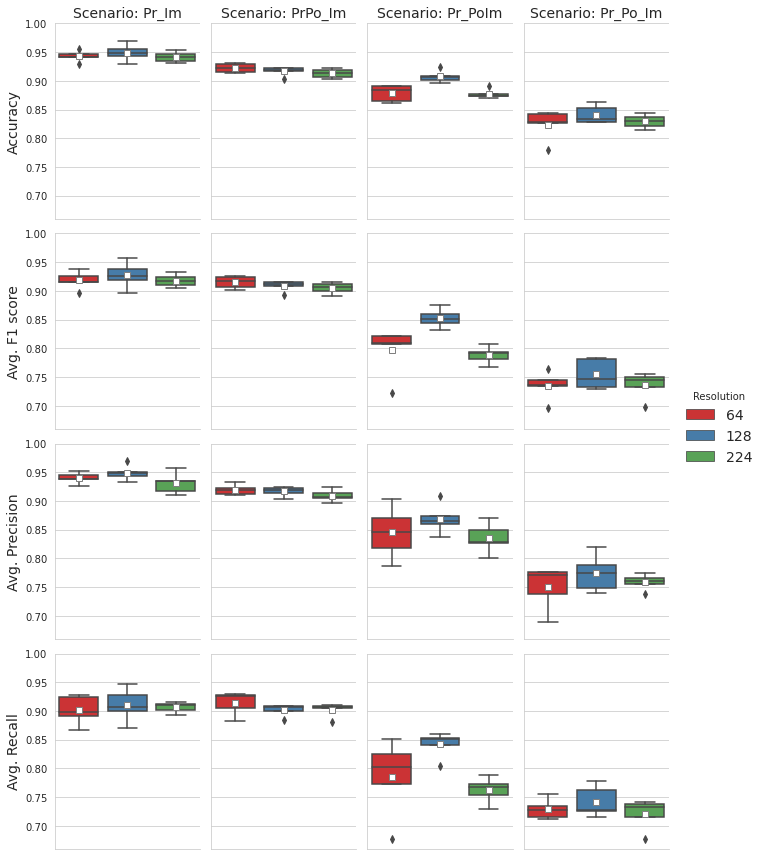

In [382]:
def plotSummaryValidationMetrics(type="box", facet=True, metrics="performance"):
    dp = getPerformanceDataFrame()    
    df = dp.loc[dp.groupby(['scenario','resolution','trial'])['val_accuracy'].idxmax()]
    num_resolutions = len(dp.resolution.unique())
    df.resolution = df.resolution.astype(object)
    if metrics=="performance":
        value_variables = ["val_accuracy", "val_f1", "val_precision", "val_recall"]
        row_labels = ["Accuracy", "Avg. F1 score", "Avg. Precision", "Avg. Recall"]
    else:
        value_variables = ["val_loss", "val_accuracy", "val_f1", "val_precision", "val_recall"]
        row_labels = ["Loss", "Accuracy", "Avg. F1 score", "Avg. Precision", "Avg. Recall"]
    #df = df[['scenario', "resolution", "trial", 'best_val_accuracy']].drop_duplicates()
    df = df.melt(id_vars = ['scenario','resolution','trial'], value_vars = value_variables,  var_name = "metric", value_name = "value")  
    #df = df.melt(id_vars = ['scenario', "resolution", "trial"], value_vars = [metric], var_name = "metric", value_name = "value")    
    if facet==True:
        g = sns.FacetGrid(df, col="scenario", row = "metric", sharey = True,  col_order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"], aspect=.8)
        if type=="box":
            g.map_dataframe(sns.boxplot, x = "resolution", y = "value", hue = "resolution", 
                        palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge = False,
                        showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"})#, capsize = .2, errwidth=1.2)
            g.set(ylim =(.66,1))
            g.add_legend(fontsize=14, title="Resolution", title_fontsize=14)#,bbox_to_anchor=(.9, .6), loc=2 )#, labels = row_labels) 
            #g._legend(title_fontsize=18)
        elif type=="point":
            g.map_dataframe(sns.pointplot, x = "resolution", y = "value",  capsize = .2, errwidth=1.2)
            g.set(ylim =(.89,1.0))       
        g.set_xticklabels([])
        #g.set_axis_labels("Resolution", "Validation Accuracy")
        axes = g.axes
        for row, axlist in enumerate(axes):
            for col, axis in enumerate(axes[row]):
                if col==0:
                    axes[row,0].set_ylabel(row_labels[row], fontsize=14)
                if row==0:
                    axes[row,col].set_title("Scenario: " + str(axes[row,col].title).split("scenario = ")[1].split(")")[0].split("\'")[0], fontsize=14)
                else:
                    axes[row,col].set_title("")
                # axes[-1, col].set_xlabel("Resolution")
        g.tight_layout()
        g.savefig("../../figures/scenario_resolution_performance_metrics_facet_" + type + "plot.png", dpi=180)
    elif facet==False:
        #plt.figure(figsize=(14,4))
        #ax = plt.subplot(121)
        if type=="box":
            g = sns.boxplot( x = "scenario", y = "value", hue = "resolution", data = df, 
                            showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
        elif type=="bar":
            g = sns.barplot( x = "scenario", y = "value", hue = "resolution", data = df,  ci=None, order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"],
                            #showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
            g.set(yticks = np.arange(0,1,.1))
        elif type=="point":
            g = sns.pointplot(x = "scenario", y = "value", hue = "resolution", data = df, palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge=True,capsize = .2, errwidth=1.2, boxprops=dict(alpha=.3))#, ax=ax)            
        g.legend(bbox_to_anchor=(1.05, 1), loc=2, title= "Resolution",borderaxespad=0.)
        g.set(xlabel="Scenario", ylabel="Validation Accuracy")
        g.get_figure().tight_layout()
        g.get_figure().savefig("../../figures/scenario_resolution_performance_metrics" + type + "plot.png", dpi=180)
    return
plotSummaryValidationMetrics()

In [91]:
def plotSummaryValidationAccuracy(type="box", facet=True, metric="val_accuracy"):
    df = getPerformanceDataFrame()    
    df = dp.groupby(['resolution','scenario','trial']).agg('max')
    df = df.reset_index()
    #df = df[['scenario', "resolution", "trial", 'best_val_accuracy']].drop_duplicates()
    num_resolutions = 3#len(df.resolution.unique())
    df.resolution = df.resolution.astype(object)
    df = df.melt(id_vars = ['scenario', "resolution", "trial"], value_vars = [metric], var_name = "metric", value_name = "value")    
    if facet==True:
        g = sns.FacetGrid(df, col="scenario", sharey = True,  col_order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"])
        if type=="box":
            g.map_dataframe(sns.boxplot, x = "resolution", y = "value", hue = "resolution", 
                        palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge =False,
                        showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"})#, capsize = .2, errwidth=1.2)
            g.set(ylim =(.85,1.01))
        elif type=="point":
            g.map_dataframe(sns.pointplot, x = "resolution", y = "value",  capsize = .2, errwidth=1.2)
            g.set(ylim =(.89,1.0))        
        g.set_axis_labels("Resolution", "Validation Accuracy")
        axes = g.axes
        for row, axlist in enumerate(axes):
            for col, axis in enumerate(axes[row]):
                axes[row,col].set_title("Scenario: " + 
                                     str(axes[row,col].title).split("scenario = ")[1].split(")")[0].split("\'")[0])
        g.savefig("../../figures/scenario_resolution_validation_accuracy_facet_" + type + "plot.png", dpi=180)
    elif facet==False:
        #plt.figure(figsize=(14,4))
        #ax = plt.subplot(121)
        if type=="box":
            g = sns.boxplot( x = "scenario", y = "value", hue = "resolution", data = df, 
                            showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
        elif type=="bar":
            g = sns.barplot( x = "scenario", y = "value", hue = "resolution", data = df,  ci=None, order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"],
                            #showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
            g.set(yticks = np.arange(0,1,.1))
        elif type=="point":
            g = sns.pointplot(x = "scenario", y = "value", hue = "resolution", data = df, palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge=True,capsize = .2, errwidth=1.2, boxprops=dict(alpha=.3))#, ax=ax)            
        g.legend(bbox_to_anchor=(1.05, 1), loc=2, title= "Resolution",borderaxespad=0.)
        g.set(xlabel="Scenario", ylabel="Validation Accuracy")
        g.get_figure().tight_layout()
        g.get_figure().savefig("../../figures/scenario_resolution_validation_accuracy_" + type + "plot.png", dpi=180)
    return

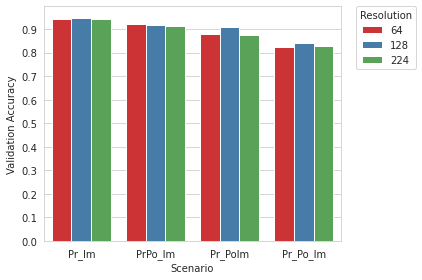

In [92]:
plotSummaryValidationAccuracy("bar", facet=False)

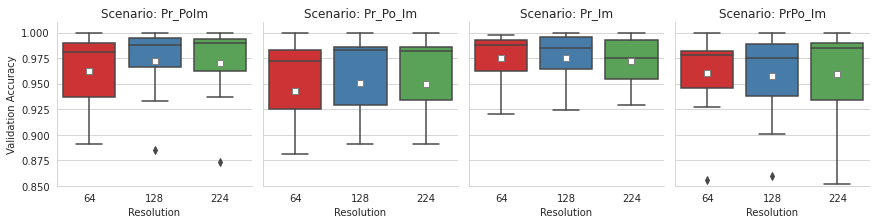

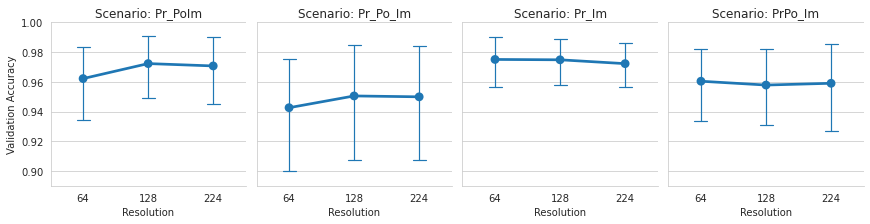

In [202]:
plotSummaryValidationAccuracy("box", facet=True)
plotSummaryValidationAccuracy("point", facet=True)

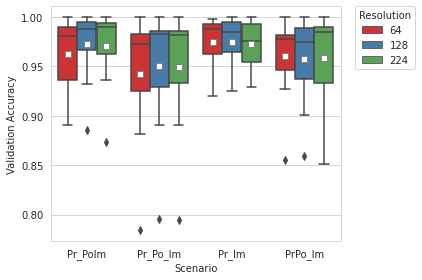

In [223]:
plotSummaryValidationAccuracy("box", facet=False)

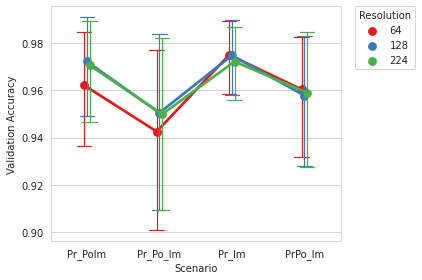

In [224]:
plotSummaryValidationAccuracy("point", facet=False)